<a href="https://colab.research.google.com/github/cerezamo/dl_ensae2020/blob/master/TEST_USPS_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - CycleGAN - ENSAE 2020 

## From MNIST to USPS 

### Import packages 

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torchvision.utils as utils
import torch.nn.functional as F
import torch.utils as tutils
from torchvision import datasets
from torchvision import transforms
import numpy as np

This code is adapted from [yunjey](https://github.com/yunjey/)

### Download and construct loaders for USPS and Mnist

In [0]:

batch_size = 64
image_size = 32



In [0]:
def get_loader_mnist(image_size,batch_size):
  transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])
  
  mnist_train = datasets.MNIST(root='content/',download=True, transform = transform,train=True)
  mnist_test = datasets.MNIST(root='content/',download=True, transform = transform,train=False)

  train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                             batch_size=batch_size,
                                             shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                             batch_size=batch_size,
                                             shuffle=False)
  
  return train_loader, test_loader 

In [0]:
def get_loader_usps(image_size,batch_size):
  transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])
  
  usps_train = datasets.USPS(root='content/',download=True, transform = transform,train=True)
  usps_test = datasets.USPS(root='content/',download=True, transform = transform,train=False)

  train_loader = torch.utils.data.DataLoader(dataset=usps_train,
                                             batch_size=batch_size,
                                             shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(dataset=usps_test,
                                             batch_size=batch_size,
                                             shuffle=False)
  
  return train_loader, test_loader 

In [0]:
M_train_loader, M_test_loader =get_loader_mnist(32,64)

In [0]:
U_train_loader, U_test_loader =get_loader_usps(32,64)

In [0]:
examples_mnist = enumerate(M_train_loader)
batch_idx, (example_data_mnist, example_targets_mnist) = next(examples_mnist)

examples_usps = enumerate(U_train_loader)
batch_idx, (example_data_usps, example_targets_usps) = next(examples_usps)

In [17]:
example_data_usps.shape, example_data_mnist.shape # 64 per batch, size 32x32  # 64 per batch, size 32x32 

(torch.Size([64, 1, 32, 32]), torch.Size([64, 1, 32, 32]))

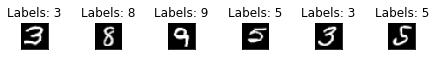

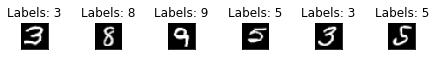

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(1,6,i+1)
  plt.tight_layout()
  plt.imshow(example_data_mnist[i][0], cmap='gray', interpolation='none')
  plt.title("Labels: {}".format(example_targets_mnist[i]))
  plt.xticks([])
  plt.yticks([])
fig

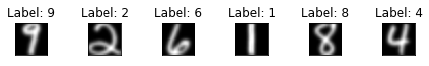

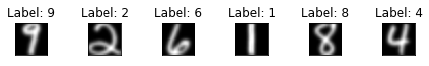

In [22]:

fig = plt.figure()
for i in range(6):
  plt.subplot(1,6,i+1)
  plt.tight_layout()
  plt.imshow(example_data_usps[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets_usps[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [10]:
example_data_mnist.size()

torch.Size([64, 1, 32, 32])

Helper functions (taken from github Cycle gan) 

In [0]:
import torch.nn as nn

In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

# Batch norm True False (last layer)

Construction of the two discriminators 

In [0]:
class D_MNIST(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D_MNIST, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

class D_USPS(nn.Module):
    """Discriminator for svhn."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D_USPS, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, bn=False) #1
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out


Creating the two generators 

In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer """
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer """
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
class G_MNIST_USPS(nn.Module):
    """Generator for transfering from mnist to usps"""
    def __init__(self, conv_dim=64):
        super(G_MNIST_USPS, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, bn=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = F.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out

class G_USPS_MNIST(nn.Module):
    """Generator for transfering from usps to mnist"""
    def __init__(self, conv_dim=64):
        super(G_USPS_MNIST, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, bn=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        return out


Building model 

In [0]:
def print_models(G_MtoU, G_UtoM, D_M, D_U):
    """Prints model information for the generators and discriminators.
    """
    print("                 G_MtoU                ")
    print("---------------------------------------")
    print(G_MtoU)
    print("---------------------------------------")

    print("                 G_UtoM                ")
    print("---------------------------------------")
    print(G_UtoM)
    print("---------------------------------------")

    print("                  D_M                  ")
    print("---------------------------------------")
    print(D_M)
    print("---------------------------------------")

    print("                  D_U                  ")
    print("---------------------------------------")
    print(D_U)
    print("---------------------------------------")

In [0]:
def create_model():
  G_MtoU = G_MNIST_USPS()
  G_UtoM = G_USPS_MNIST()
  D_M = D_MNIST()
  D_U = D_USPS()

  print_models(G_MtoU, G_UtoM, D_M, D_U)

  if torch.cuda.is_available():
      G_MtoU.cuda()
      G_UtoM.cuda()
      D_M.cuda()
      D_U.cuda()
      print('Models moved to GPU.')
  return G_MtoU,G_UtoM, D_M, D_U

In [0]:
def save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU):
    """Saves samples from both generators M->U and U->M.
    """
    import os
    import imageio
    fake_M = G_UtoM(fixed_U)
    fake_U = G_MtoU(fixed_M)

    M, fake_M = to_data(fixed_M), to_data(fake_M)
    U, fake_U = to_data(fixed_U), to_data(fake_U)

    merged = merge_images(M, fake_U)
    path = os.path.join('/content/', 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(U, fake_M)
    path = os.path.join('/content/', 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [0]:
def merge_images(sources, targets, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    row = int(np.sqrt(64))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)

Helper functions 

In [0]:
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

### Training loop

In [0]:
def training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=20000, log_step = 10, batch_size=64, use_cycle_consistency_loss=True):
  # Create generators and discriminators
  G_MtoU, G_UtoM, D_M, D_U = create_model()

  g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())  # Get generator parameters
  d_params = list(D_M.parameters()) + list(D_U.parameters())  # Get discriminator parameters

  # Create optimizers for the generators and discriminators
  g_optimizer = optim.Adam(g_params, lr)
  d_optimizer = optim.Adam(d_params, lr)

  iter_M = iter(M_train_loader)
  iter_U = iter(U_train_loader)

  test_iter_M = iter(M_test_loader)
  test_iter_U = iter(U_test_loader)

  # Get some fixed data from domains X and Y for sampling. These are images that are held
  # constant throughout training, that allow us to inspect the model's performance.
  fixed_M = to_var(test_iter_M.next()[0])
  fixed_U = to_var(test_iter_U.next()[0])

  iter_per_epoch = min(len(iter_M), len(iter_U))



  for iteration in range(1, train_iters+1):

      # Reset data_iter for each epoch
      if iteration % iter_per_epoch == 0:
          iter_M = iter(M_train_loader)
          iter_U = iter(U_train_loader)

      images_M, labels_M = iter_M.next()
      images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

      images_U, labels_U = iter_U.next()
      images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()


      # ============================================
      #            TRAIN THE DISCRIMINATORS
      # ============================================

      # Train with real images
      d_optimizer.zero_grad()

      # Compute the discriminator losses on real images
      out_M = D_M(images_M) # discriminator mnist true
      D_M_loss = torch.mean((out_M-1)**2) 
      out_U = D_U(images_U)
      D_U_loss = torch.mean((out_U-1)**2)

      d_real_loss = D_M_loss + D_U_loss
      d_real_loss.backward()
      d_optimizer.step()

      # Train with fake images
      d_optimizer.zero_grad()

      # Generate fake images that look like domain MNIST based on real images in domain USPS
      fake_M = G_UtoM(images_U)

      # Compute the loss for D_M
      out_M = D_M(fake_M)
      D_M_loss = torch.mean((out_M-1)**2) 

      # 4. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_MtoU(images_M)

      # 5. Compute the loss for D_U
      out_U = D_U(fake_U)
      D_U_loss = torch.mean((out_U-1)**2) 

      d_fake_loss = D_M_loss + D_U_loss
      d_fake_loss.backward()
      d_optimizer.step()



      # =========================================
      #            TRAIN THE GENERATORS
      # =========================================

      ## U--M-->U 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain M based on real images in domain U
      fake_M = G_UtoM(images_U)
      out = D_M(fake_M)

      # 2. Compute the generator loss based on domain M

      g_loss = torch.mean((out-1)**2)

      if use_cycle_consistency_loss:
          reconstructed_U = G_MtoU(fake_M)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()

      ## M--U-->M 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_MtoU(images_M)
      out = D_U(fake_U)

      # 2. Compute the generator loss based on domain U
      g_loss = torch.mean((out-1)**2)

      if use_cycle_consistency_loss:
          reconstructed_M = G_UtoM(fake_U)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()


      # Print the log info
      if iteration % log_step == 0:
          print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                  D_M_loss.item(), d_fake_loss.item(), g_loss.item()))


      # Save the generated samples
      if iteration % sample_every == 0:
          save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU)

In [34]:
training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=20000, log_step = 10,  use_cycle_consistency_loss=True)

                 G_MtoU                
---------------------------------------
G_MNIST_USPS(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration [   10/20000] | d_real_loss: 0.6263 | d_Y_loss: 0.0634 | d_X_loss: 0.0726 | d_fake_loss: 0.1360 | g_loss: 0.7087
Iteration [   20/20000] | d_real_loss: 0.0740 | d_Y_loss: 0.0238 | d_X_loss: 0.0557 | d_fake_loss: 0.0795 | g_loss: 0.3436
Iteration [   30/20000] | d_real_loss: 0.0402 | d_Y_loss: 0.0123 | d_X_loss: 0.0258 | d_fake_loss: 0.0382 | g_loss: 0.2352
Iteration [   40/20000] | d_real_loss: 0.0184 | d_Y_loss: 0.0113 | d_X_loss: 0.0156 | d_fake_loss: 0.0269 | g_loss: 0.1904
Iteration [   50/20000] | d_real_loss: 0.0199 | d_Y_loss: 0.0080 | d_X_loss: 0.0157 | d_fake_loss: 0.0236 | g_loss: 0.1627
Iteration [   60/20000] | d_real_loss: 0.0154 | d_Y_loss: 0.0110 | d_X_loss: 0.0132 | d_fake_loss: 0.0243 | g_loss: 0.1412
Iteration [   70/20000] | d_real_loss: 0.0153 | d_Y_loss: 0.0157 | d_X_loss: 0.0092 | d_fake_loss: 0.0249 | g_loss: 0.1261
Iteration [   80/20000] | d_real_loss: 0.0163 | d_Y_loss: 0.0076 | d_X_loss: 0.0161 | d_fake_loss: 0.0237 | g_loss: 0.1130
Iteration [   90

Iteration [ 1000/20000] | d_real_loss: 0.0018 | d_Y_loss: 0.0020 | d_X_loss: 0.0005 | d_fake_loss: 0.0025 | g_loss: 0.0086
Saved /content/sample-001000-X-Y.png
Saved /content/sample-001000-Y-X.png
Iteration [ 1010/20000] | d_real_loss: 0.0025 | d_Y_loss: 0.0022 | d_X_loss: 0.0007 | d_fake_loss: 0.0029 | g_loss: 0.0080
Iteration [ 1020/20000] | d_real_loss: 0.0023 | d_Y_loss: 0.0003 | d_X_loss: 0.0016 | d_fake_loss: 0.0019 | g_loss: 0.0093
Iteration [ 1030/20000] | d_real_loss: 0.0014 | d_Y_loss: 0.0004 | d_X_loss: 0.0017 | d_fake_loss: 0.0021 | g_loss: 0.0072
Iteration [ 1040/20000] | d_real_loss: 0.0018 | d_Y_loss: 0.0012 | d_X_loss: 0.0010 | d_fake_loss: 0.0022 | g_loss: 0.0087
Iteration [ 1050/20000] | d_real_loss: 0.0028 | d_Y_loss: 0.0010 | d_X_loss: 0.0016 | d_fake_loss: 0.0026 | g_loss: 0.0082
Iteration [ 1060/20000] | d_real_loss: 0.0016 | d_Y_loss: 0.0009 | d_X_loss: 0.0007 | d_fake_loss: 0.0016 | g_loss: 0.0087
Iteration [ 1070/20000] | d_real_loss: 0.0019 | d_Y_loss: 0.0024 

Iteration [ 2000/20000] | d_real_loss: 0.0022 | d_Y_loss: 0.0026 | d_X_loss: 0.0010 | d_fake_loss: 0.0036 | g_loss: 0.0047
Saved /content/sample-002000-X-Y.png
Saved /content/sample-002000-Y-X.png
Iteration [ 2010/20000] | d_real_loss: 0.0018 | d_Y_loss: 0.0011 | d_X_loss: 0.0004 | d_fake_loss: 0.0016 | g_loss: 0.0046
Iteration [ 2020/20000] | d_real_loss: 0.0029 | d_Y_loss: 0.0007 | d_X_loss: 0.0011 | d_fake_loss: 0.0018 | g_loss: 0.0055
Iteration [ 2030/20000] | d_real_loss: 0.0011 | d_Y_loss: 0.0002 | d_X_loss: 0.0003 | d_fake_loss: 0.0006 | g_loss: 0.0052
Iteration [ 2040/20000] | d_real_loss: 0.0010 | d_Y_loss: 0.0014 | d_X_loss: 0.0007 | d_fake_loss: 0.0022 | g_loss: 0.0052
Iteration [ 2050/20000] | d_real_loss: 0.0017 | d_Y_loss: 0.0009 | d_X_loss: 0.0009 | d_fake_loss: 0.0018 | g_loss: 0.0047
Iteration [ 2060/20000] | d_real_loss: 0.0017 | d_Y_loss: 0.0033 | d_X_loss: 0.0011 | d_fake_loss: 0.0044 | g_loss: 0.0054
Iteration [ 2070/20000] | d_real_loss: 0.0020 | d_Y_loss: 0.0003 

Iteration [ 3000/20000] | d_real_loss: 0.0029 | d_Y_loss: 0.0001 | d_X_loss: 0.0005 | d_fake_loss: 0.0007 | g_loss: 0.0036
Saved /content/sample-003000-X-Y.png
Saved /content/sample-003000-Y-X.png
Iteration [ 3010/20000] | d_real_loss: 0.0027 | d_Y_loss: 0.0002 | d_X_loss: 0.0006 | d_fake_loss: 0.0008 | g_loss: 0.0037
Iteration [ 3020/20000] | d_real_loss: 0.0011 | d_Y_loss: 0.0001 | d_X_loss: 0.0004 | d_fake_loss: 0.0004 | g_loss: 0.0036
Iteration [ 3030/20000] | d_real_loss: 0.0033 | d_Y_loss: 0.0012 | d_X_loss: 0.0004 | d_fake_loss: 0.0017 | g_loss: 0.0036
Iteration [ 3040/20000] | d_real_loss: 0.0009 | d_Y_loss: 0.0031 | d_X_loss: 0.0009 | d_fake_loss: 0.0041 | g_loss: 0.0036
Iteration [ 3050/20000] | d_real_loss: 0.0039 | d_Y_loss: 0.0002 | d_X_loss: 0.0007 | d_fake_loss: 0.0009 | g_loss: 0.0033
Iteration [ 3060/20000] | d_real_loss: 0.0008 | d_Y_loss: 0.0013 | d_X_loss: 0.0004 | d_fake_loss: 0.0018 | g_loss: 0.0032
Iteration [ 3070/20000] | d_real_loss: 0.0016 | d_Y_loss: 0.0001 

Iteration [ 4000/20000] | d_real_loss: 0.0009 | d_Y_loss: 0.0003 | d_X_loss: 0.0001 | d_fake_loss: 0.0004 | g_loss: 0.0037
Saved /content/sample-004000-X-Y.png
Saved /content/sample-004000-Y-X.png
Iteration [ 4010/20000] | d_real_loss: 0.0009 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0002 | g_loss: 0.0028
Iteration [ 4020/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0006 | d_X_loss: 0.0002 | d_fake_loss: 0.0008 | g_loss: 0.0030
Iteration [ 4030/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0008 | d_X_loss: 0.0003 | d_fake_loss: 0.0011 | g_loss: 0.0027
Iteration [ 4040/20000] | d_real_loss: 0.0014 | d_Y_loss: 0.0043 | d_X_loss: 0.0009 | d_fake_loss: 0.0052 | g_loss: 0.0030
Iteration [ 4050/20000] | d_real_loss: 0.0008 | d_Y_loss: 0.0002 | d_X_loss: 0.0003 | d_fake_loss: 0.0004 | g_loss: 0.0025
Iteration [ 4060/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0003 | d_X_loss: 0.0004 | d_fake_loss: 0.0007 | g_loss: 0.0024
Iteration [ 4070/20000] | d_real_loss: 0.0008 | d_Y_loss: 0.0002 

Iteration [ 5000/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0002 | g_loss: 0.0025
Saved /content/sample-005000-X-Y.png
Saved /content/sample-005000-Y-X.png
Iteration [ 5010/20000] | d_real_loss: 0.0016 | d_Y_loss: 0.0011 | d_X_loss: 0.0001 | d_fake_loss: 0.0012 | g_loss: 0.0022
Iteration [ 5020/20000] | d_real_loss: 0.0010 | d_Y_loss: 0.0006 | d_X_loss: 0.0002 | d_fake_loss: 0.0008 | g_loss: 0.0021
Iteration [ 5030/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0006 | d_X_loss: 0.0002 | d_fake_loss: 0.0008 | g_loss: 0.0027
Iteration [ 5040/20000] | d_real_loss: 0.0013 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0002 | g_loss: 0.0029
Iteration [ 5050/20000] | d_real_loss: 0.0012 | d_Y_loss: 0.0002 | d_X_loss: 0.0001 | d_fake_loss: 0.0004 | g_loss: 0.0022
Iteration [ 5060/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0002 | d_X_loss: 0.0002 | d_fake_loss: 0.0005 | g_loss: 0.0025
Iteration [ 5070/20000] | d_real_loss: 0.0009 | d_Y_loss: 0.0002 

Iteration [ 6000/20000] | d_real_loss: 0.0009 | d_Y_loss: 0.0001 | d_X_loss: 0.0005 | d_fake_loss: 0.0006 | g_loss: 0.0017
Saved /content/sample-006000-X-Y.png
Saved /content/sample-006000-Y-X.png
Iteration [ 6010/20000] | d_real_loss: 0.0006 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0022
Iteration [ 6020/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0002 | d_X_loss: 0.0001 | d_fake_loss: 0.0003 | g_loss: 0.0034
Iteration [ 6030/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0003 | d_X_loss: 0.0001 | d_fake_loss: 0.0004 | g_loss: 0.0019
Iteration [ 6040/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0002 | d_X_loss: 0.0001 | d_fake_loss: 0.0003 | g_loss: 0.0021
Iteration [ 6050/20000] | d_real_loss: 0.0007 | d_Y_loss: 0.0003 | d_X_loss: 0.0003 | d_fake_loss: 0.0007 | g_loss: 0.0025
Iteration [ 6060/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0012 | d_X_loss: 0.0001 | d_fake_loss: 0.0013 | g_loss: 0.0036
Iteration [ 6070/20000] | d_real_loss: 0.0009 | d_Y_loss: 0.0045 

Iteration [ 7000/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0024 | d_X_loss: 0.0003 | d_fake_loss: 0.0026 | g_loss: 0.0015
Saved /content/sample-007000-X-Y.png
Saved /content/sample-007000-Y-X.png
Iteration [ 7010/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0010 | d_X_loss: 0.0004 | d_fake_loss: 0.0014 | g_loss: 0.0015
Iteration [ 7020/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0015
Iteration [ 7030/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0004 | d_X_loss: 0.0001 | d_fake_loss: 0.0005 | g_loss: 0.0016
Iteration [ 7040/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0003 | d_X_loss: 0.0000 | d_fake_loss: 0.0003 | g_loss: 0.0015
Iteration [ 7050/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0018
Iteration [ 7060/20000] | d_real_loss: 0.0007 | d_Y_loss: 0.0000 | d_X_loss: 0.0002 | d_fake_loss: 0.0002 | g_loss: 0.0017
Iteration [ 7070/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 

Iteration [ 8000/20000] | d_real_loss: 0.0009 | d_Y_loss: 0.0005 | d_X_loss: 0.0002 | d_fake_loss: 0.0007 | g_loss: 0.0021
Saved /content/sample-008000-X-Y.png
Saved /content/sample-008000-Y-X.png
Iteration [ 8010/20000] | d_real_loss: 0.0006 | d_Y_loss: 0.0009 | d_X_loss: 0.0001 | d_fake_loss: 0.0010 | g_loss: 0.0018
Iteration [ 8020/20000] | d_real_loss: 0.0014 | d_Y_loss: 0.0011 | d_X_loss: 0.0001 | d_fake_loss: 0.0012 | g_loss: 0.0021
Iteration [ 8030/20000] | d_real_loss: 0.0019 | d_Y_loss: 0.0021 | d_X_loss: 0.0001 | d_fake_loss: 0.0022 | g_loss: 0.0035
Iteration [ 8040/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0034 | d_X_loss: 0.0001 | d_fake_loss: 0.0035 | g_loss: 0.0018
Iteration [ 8050/20000] | d_real_loss: 0.0006 | d_Y_loss: 0.0008 | d_X_loss: 0.0000 | d_fake_loss: 0.0008 | g_loss: 0.0018
Iteration [ 8060/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0001 | d_X_loss: 0.0002 | d_fake_loss: 0.0002 | g_loss: 0.0015
Iteration [ 8070/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0008 

Iteration [ 9000/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0015
Saved /content/sample-009000-X-Y.png
Saved /content/sample-009000-Y-X.png
Iteration [ 9010/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0016
Iteration [ 9020/20000] | d_real_loss: 0.0008 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0002 | g_loss: 0.0012
Iteration [ 9030/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0011
Iteration [ 9040/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0014
Iteration [ 9050/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0005 | d_X_loss: 0.0000 | d_fake_loss: 0.0005 | g_loss: 0.0014
Iteration [ 9060/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0003 | d_X_loss: 0.0001 | d_fake_loss: 0.0004 | g_loss: 0.0017
Iteration [ 9070/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 

Iteration [10000/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0007 | d_X_loss: 0.0000 | d_fake_loss: 0.0007 | g_loss: 0.0016
Saved /content/sample-010000-X-Y.png
Saved /content/sample-010000-Y-X.png
Iteration [10010/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0003 | d_X_loss: 0.0000 | d_fake_loss: 0.0004 | g_loss: 0.0013
Iteration [10020/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0002 | d_X_loss: 0.0000 | d_fake_loss: 0.0002 | g_loss: 0.0010
Iteration [10030/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0011
Iteration [10040/20000] | d_real_loss: 0.0007 | d_Y_loss: 0.0007 | d_X_loss: 0.0000 | d_fake_loss: 0.0007 | g_loss: 0.0016
Iteration [10050/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0006 | d_X_loss: 0.0001 | d_fake_loss: 0.0007 | g_loss: 0.0013
Iteration [10060/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0011
Iteration [10070/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0003 

Iteration [11000/20000] | d_real_loss: 0.0008 | d_Y_loss: 0.0000 | d_X_loss: 0.0004 | d_fake_loss: 0.0005 | g_loss: 0.0011
Saved /content/sample-011000-X-Y.png
Saved /content/sample-011000-Y-X.png
Iteration [11010/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0011
Iteration [11020/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0003 | d_X_loss: 0.0000 | d_fake_loss: 0.0003 | g_loss: 0.0009
Iteration [11030/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0000 | d_X_loss: 0.0003 | d_fake_loss: 0.0003 | g_loss: 0.0011
Iteration [11040/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0002 | g_loss: 0.0011
Iteration [11050/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0003 | d_fake_loss: 0.0003 | g_loss: 0.0010
Iteration [11060/20000] | d_real_loss: 0.0010 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0013
Iteration [11070/20000] | d_real_loss: 0.0010 | d_Y_loss: 0.0000 

Iteration [12000/20000] | d_real_loss: 0.0006 | d_Y_loss: 0.0001 | d_X_loss: 0.0002 | d_fake_loss: 0.0002 | g_loss: 0.0010
Saved /content/sample-012000-X-Y.png
Saved /content/sample-012000-Y-X.png
Iteration [12010/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0003 | d_X_loss: 0.0003 | d_fake_loss: 0.0006 | g_loss: 0.0010
Iteration [12020/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0002 | g_loss: 0.0011
Iteration [12030/20000] | d_real_loss: 0.0020 | d_Y_loss: 0.0003 | d_X_loss: 0.0001 | d_fake_loss: 0.0004 | g_loss: 0.0016
Iteration [12040/20000] | d_real_loss: 0.0010 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0014
Iteration [12050/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0002 | d_X_loss: 0.0000 | d_fake_loss: 0.0002 | g_loss: 0.0011
Iteration [12060/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0009
Iteration [12070/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0003 

Iteration [13000/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0002 | d_X_loss: 0.0002 | d_fake_loss: 0.0004 | g_loss: 0.0015
Saved /content/sample-013000-X-Y.png
Saved /content/sample-013000-Y-X.png
Iteration [13010/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0004 | d_X_loss: 0.0000 | d_fake_loss: 0.0004 | g_loss: 0.0012
Iteration [13020/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0010
Iteration [13030/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0009
Iteration [13040/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0013
Iteration [13050/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0010
Iteration [13060/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0010
Iteration [13070/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 

Iteration [14000/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0013
Saved /content/sample-014000-X-Y.png
Saved /content/sample-014000-Y-X.png
Iteration [14010/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0015
Iteration [14020/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0009
Iteration [14030/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0010
Iteration [14040/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0010
Iteration [14050/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0016
Iteration [14060/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0010
Iteration [14070/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 

Iteration [15000/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0008
Saved /content/sample-015000-X-Y.png
Saved /content/sample-015000-Y-X.png
Iteration [15010/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0008
Iteration [15020/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0008
Iteration [15030/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0008
Iteration [15040/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0008
Iteration [15050/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0002 | g_loss: 0.0009
Iteration [15060/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0009
Iteration [15070/20000] | d_real_loss: 0.0004 | d_Y_loss: 0.0007 

Iteration [16000/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0005 | d_X_loss: 0.0004 | d_fake_loss: 0.0009 | g_loss: 0.0009
Saved /content/sample-016000-X-Y.png
Saved /content/sample-016000-Y-X.png
Iteration [16010/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0003 | d_X_loss: 0.0003 | d_fake_loss: 0.0006 | g_loss: 0.0008
Iteration [16020/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0009
Iteration [16030/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 | d_X_loss: 0.0001 | d_fake_loss: 0.0002 | g_loss: 0.0007
Iteration [16040/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0008
Iteration [16050/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0008
Iteration [16060/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0008
Iteration [16070/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 

Iteration [17000/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0009
Saved /content/sample-017000-X-Y.png
Saved /content/sample-017000-Y-X.png
Iteration [17010/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0007
Iteration [17020/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0006
Iteration [17030/20000] | d_real_loss: 0.0000 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0008
Iteration [17040/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0007
Iteration [17050/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0008
Iteration [17060/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0007
Iteration [17070/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 

Iteration [18000/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0007
Saved /content/sample-018000-X-Y.png
Saved /content/sample-018000-Y-X.png
Iteration [18010/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0008
Iteration [18020/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0010
Iteration [18030/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0004 | d_X_loss: 0.0000 | d_fake_loss: 0.0004 | g_loss: 0.0007
Iteration [18040/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0009
Iteration [18050/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0000 | d_X_loss: 0.0001 | d_fake_loss: 0.0001 | g_loss: 0.0016
Iteration [18060/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0012
Iteration [18070/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0002 

Iteration [19000/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0006 | d_X_loss: 0.0000 | d_fake_loss: 0.0007 | g_loss: 0.0007
Saved /content/sample-019000-X-Y.png
Saved /content/sample-019000-Y-X.png
Iteration [19010/20000] | d_real_loss: 0.0005 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0002 | g_loss: 0.0013
Iteration [19020/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0008 | d_X_loss: 0.0000 | d_fake_loss: 0.0008 | g_loss: 0.0010
Iteration [19030/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0002 | d_X_loss: 0.0000 | d_fake_loss: 0.0002 | g_loss: 0.0007
Iteration [19040/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0002 | d_X_loss: 0.0000 | d_fake_loss: 0.0002 | g_loss: 0.0007
Iteration [19050/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0001 | d_X_loss: 0.0000 | d_fake_loss: 0.0001 | g_loss: 0.0009
Iteration [19060/20000] | d_real_loss: 0.0001 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0006
Iteration [19070/20000] | d_real_loss: 0.0003 | d_Y_loss: 0.0000 

Iteration [20000/20000] | d_real_loss: 0.0002 | d_Y_loss: 0.0000 | d_X_loss: 0.0000 | d_fake_loss: 0.0000 | g_loss: 0.0007
Saved /content/sample-020000-X-Y.png
Saved /content/sample-020000-Y-X.png
